<a href="https://colab.research.google.com/github/Razanhus/t5/blob/main/Razan_Time_Series_Forecasting_Practical_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
!pip install statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam


In [127]:
from sklearn.preprocessing import LabelEncoder

In [2]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
#!kaggle datasets download -d khaledzsa/traffic-dataset
#!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 79.4MB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [3]:
df=pd.read_csv('/content/Traffic Data.csv')

In [4]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [36]:
#convert date into datetime
df['date_time'] = pd.to_datetime(df['date_time'])

In [38]:
# Extract the time-related features from the 'date_time' column
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.day_name()
df['month'] = df['date_time'].dt.month

In [ ]:
df['traffic_volume'].plot()
plt.show()

In [ ]:
df['date_time'].plot()
plt.show()

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       20000 non-null  float64       
 1   temp                 20000 non-null  float64       
 2   rain_1h              20000 non-null  float64       
 3   snow_1h              20000 non-null  float64       
 4   clouds_all           20000 non-null  int64         
 5   weather_main         20000 non-null  object        
 6   weather_description  20000 non-null  object        
 7   date_time            20000 non-null  datetime64[ns]
 8   hour                 20000 non-null  int32         
 9   day_of_week          20000 non-null  object        
 10  month                20000 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(2), int64(1), object(3)
memory usage: 1.5+ MB


In [44]:
import seaborn as sns

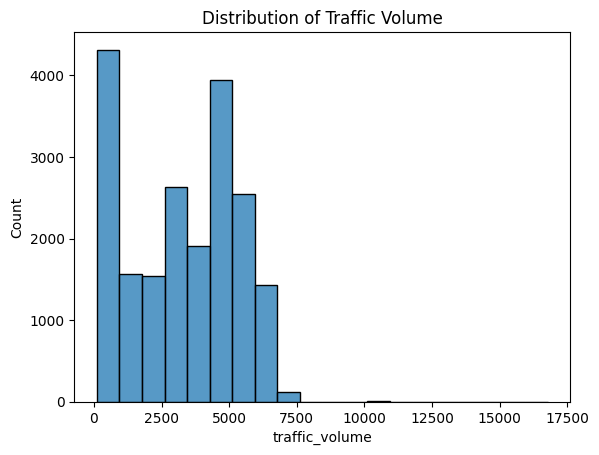

In [63]:
sns.histplot(df['traffic_volume'], bins=20)
plt.title('Distribution of Traffic Volume')
plt.show()

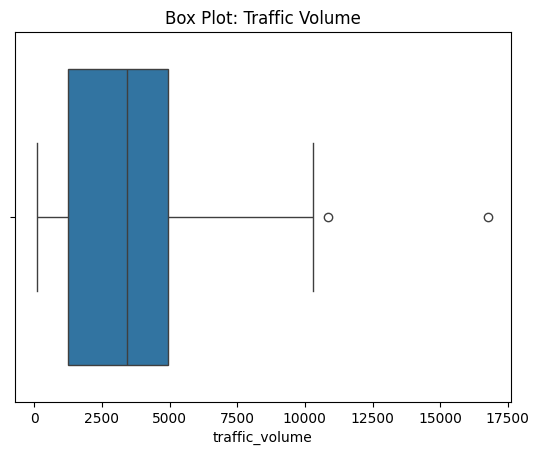

Number of Outliers: 3
       traffic_volume    temp  rain_1h  snow_1h  clouds_all weather_main  \
1193          16781.0  285.69      0.0      0.0          75         Mist   
2675          10843.0  280.82      0.0      0.0           1        Clear   
15968         10309.0  287.81      0.0      0.0           1          Fog   

      weather_description           date_time  hour day_of_week  month  
1193                 mist 2017-04-25 07:00:00     7     Tuesday      4  
2675         sky is clear 2017-11-28 04:00:00     4     Tuesday     11  
15968                 fog 2018-05-15 01:00:00     1     Tuesday      5  


In [45]:
# outliers
from scipy import stats
sns.boxplot(x=df['traffic_volume'])
plt.title('Box Plot: Traffic Volume')
plt.show()

# Identify outliers using Z-score
z_scores = np.abs(stats.zscore(df['traffic_volume']))
outliers = df[(z_scores >= 3) | (z_scores <= -3)]

# Print or analyze the outliers as needed
print(f'Number of Outliers: {len(outliers)}')
print(outliers);

In [5]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,19980.000000,20000.000000,20000.000000,20000.0,20000.000000
mean,3278.186887,281.162680,0.048396,0.0,49.384600
std,1977.171357,12.661288,0.398007,0.0,39.647341
min,113.000000,243.390000,0.000000,0.0,0.000000
25%,1228.750000,271.950000,0.000000,0.0,1.000000
50%,3430.000000,281.825000,0.000000,0.0,75.000000
75%,4928.000000,291.840000,0.000000,0.0,90.000000
max,16781.000000,310.070000,10.600000,0.0,92.000000


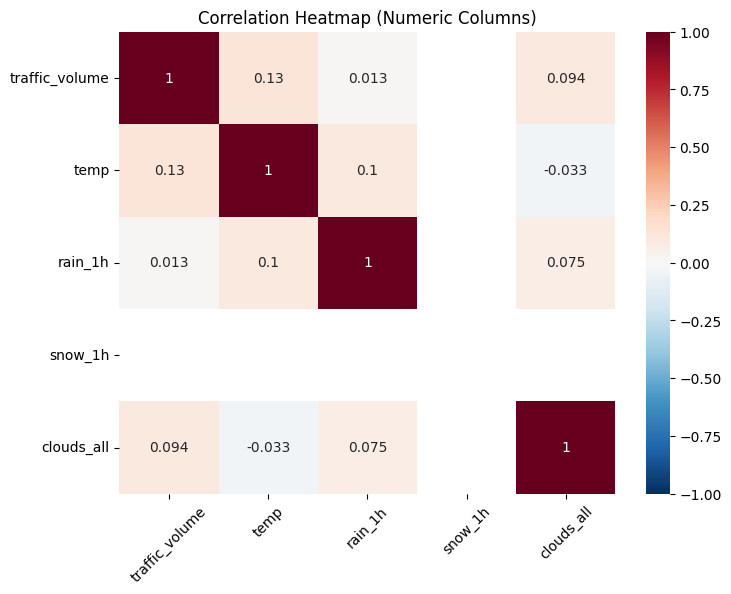

In [46]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Compute the correlation matrix for the numeric columns
corr_matrix = df[num_cols].corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Numeric Columns)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [6]:
df.isnull().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [8]:
df.dtypes

,0
traffic_volume,float64
temp,float64
rain_1h,float64
snow_1h,float64
clouds_all,int64
weather_main,object
weather_description,object
date_time,object


## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [10]:
df.ffill(inplace=True)

In [14]:
df.dtypes

,0
traffic_volume,float64
temp,float64
rain_1h,float64
snow_1h,float64
clouds_all,int64
weather_main,object
weather_description,object
date_time,datetime64[ns]


In [ ]:
df['weather_description']

In [130]:
le = LabelEncoder()
le.fit_transform(['weather_main'])
le.fit_transform(['weather_description'])


array([0])

In [129]:
#df_encoded = pd.get_dummies(df, columns=['weather_description', 'weather_main'])

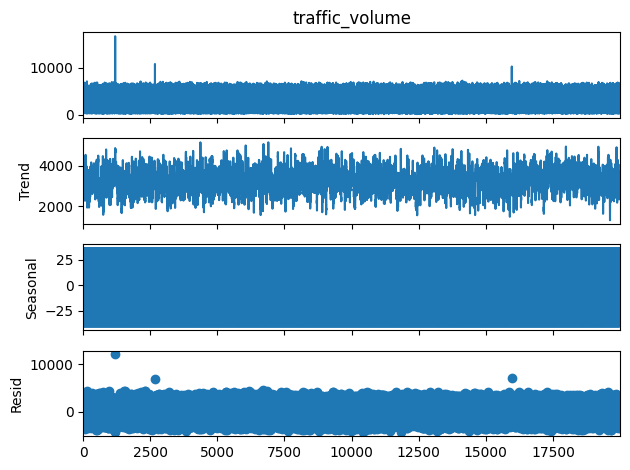

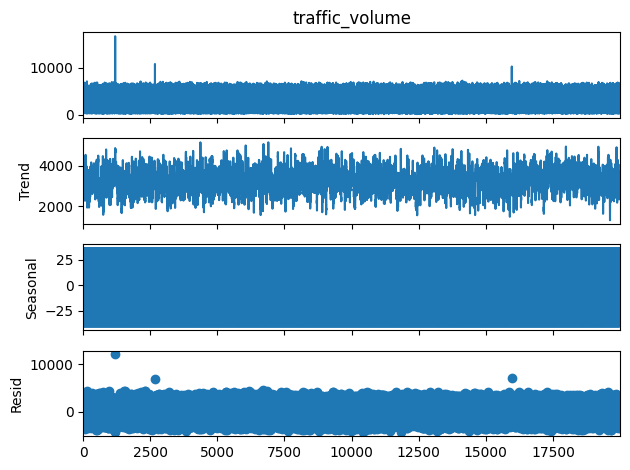

In [131]:
#result = seasonal_decompose(df['traffic_volume'], model='additive')
decomposition = seasonal_decompose(df['traffic_volume'], model='additive', period=12)
decomposition.plot()

In [49]:
df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_main', 'weather_description', 'date_time', 'hour',
       'day_of_week', 'month'],
      dtype='object')

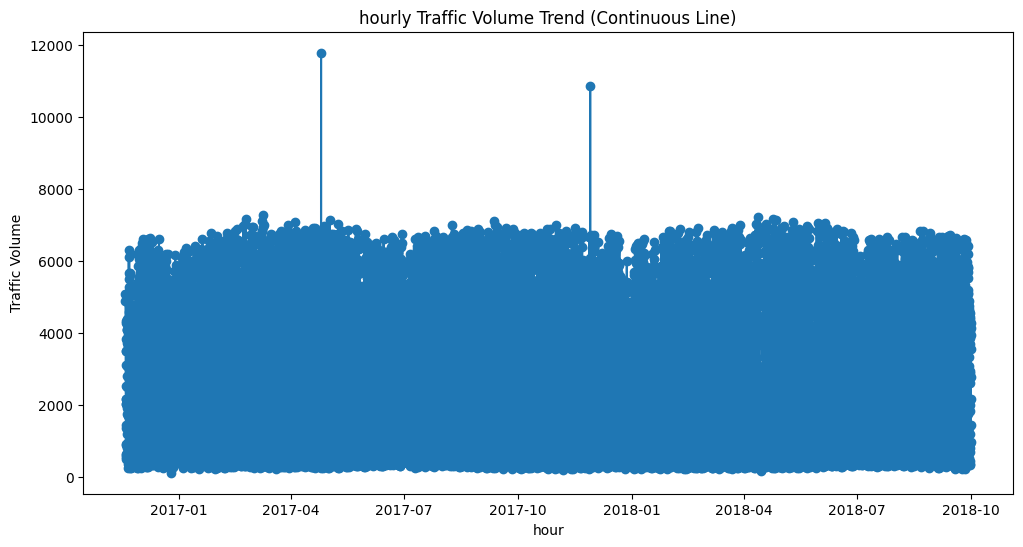

In [62]:
   # Group by hour, then calculate the mean of traffic_volume
   df['hour'] = df['date_time'].dt.to_period('h')

   df_grouped = df.groupby('hour')['traffic_volume'].mean().reset_index()

   # Convert 'hour' back to a datetime format for plotting
   df_grouped['hour'] = df_grouped['hour'].dt.to_timestamp()
   # Plotting the continuous line plot

   plt.figure(figsize=(12, 6))

   plt.plot(df_grouped['hour'], df_grouped['traffic_volume'], marker='o', linestyle='-')

plt.title('hourly Traffic Volume Trend (Continuous Line)')

plt.xlabel('hour')

plt.ylabel('Traffic Volume')

plt.show()

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [71]:
df['prev_traffic_volume'] = df['traffic_volume'].shift(1)


In [72]:
df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_main', 'weather_description', 'date_time', 'hour',
       'day_of_week', 'month', 'prev_traffic_volume'],
      dtype='object')

In [73]:
df['traffic_volume_diff'] = df['traffic_volume'].diff()

print(df)

       traffic_volume    temp  rain_1h  snow_1h  clouds_all weather_main  \
0              1209.0  291.15      0.0      0.0          90         Mist   
1              1248.0  286.01      0.0      0.0           1        Clear   
2              4602.0  293.69      0.0      0.0          75       Clouds   
3              2838.0  262.35      0.0      0.0           1        Clear   
4              5794.0  267.08      0.0      0.0           5        Clear   
...               ...     ...      ...      ...         ...          ...   
19995          2723.0  296.42      0.0      0.0          40       Clouds   
19996          5895.0  285.58      0.0      0.0          40       Clouds   
19997          1132.0  275.30      0.0      0.0           1        Clear   
19998          5525.0  260.94      0.0      0.0          75       Clouds   
19999          5042.0  301.65      0.0      0.0          40       Clouds   

      weather_description           date_time              hour day_of_week  \
0       

In [93]:
from sklearn.preprocessing import MinMaxScaler
# will use the 'Traffic Volume' column as our target variable

data = df[['traffic_volume']]

#normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [85]:
# Create sequences for the model
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)


#setting the sequence length to 20
sequence_length = 20
x, y = create_sequences(scaled_data, sequence_length)

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [86]:
x.shape, y.shape

((19980, 20), (19980,))

In [87]:
x = x.reshape(x.shape[0], x.shape[1], 1)

In [89]:
x.shape

(19980, 20, 1)

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [90]:
#split the data into training and test sets
split = int(0.8 * len(x))

x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
x_train

In [ ]:
y_train

In [ ]:
data[:5].values

In [ ]:
data[5:].values

In [94]:
x_train.shape, y_train.shape

((15984, 20, 1), (15984,))

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

**GRU
**

In [95]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

In [96]:
#building the model
model =Sequential([
    GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    GRU(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])
model.summary()
#compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 20, 50)              │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,551 (95.90 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [97]:
#train the model GRU
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - loss: 0.0157 - val_loss: 0.0139
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0142 - val_loss: 0.0138
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.0141 - val_loss: 0.0141
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.0144 - val_loss: 0.0140
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.0141 - val_loss: 0.0140
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0142 - val_loss: 0.0139
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0143 - val_loss: 0.0139
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0142 - val_loss: 0.0138
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0142 - val_loss: 0.0138


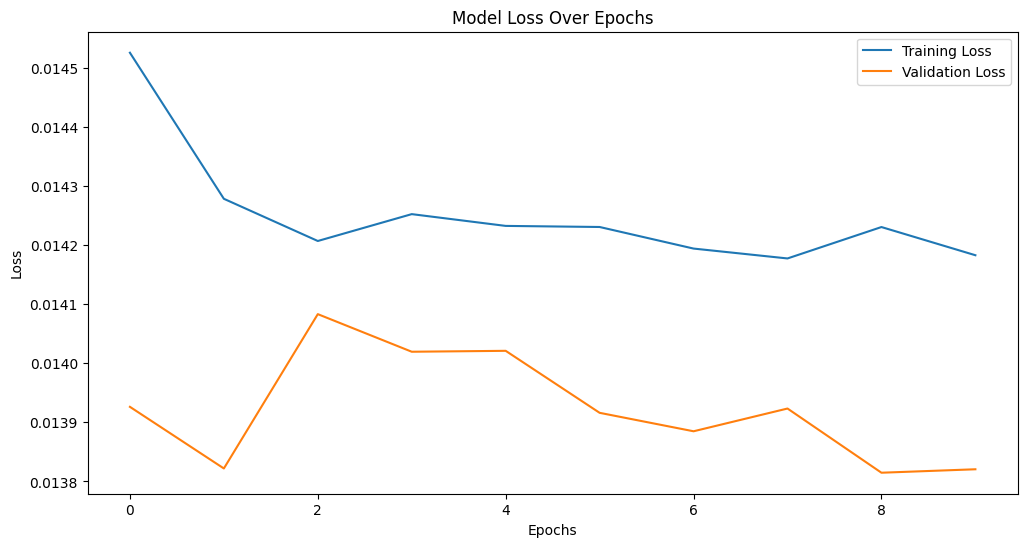

In [98]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [108]:
#lets mock my GRU model!!!
#clearly it needs to be tuned!


### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [100]:
#make predictions
predicted_traffic_vol = model.predict(x_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [152]:
# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print(f'RMSE: {rmse}')

RMSE: 1.3761667050940564e+71


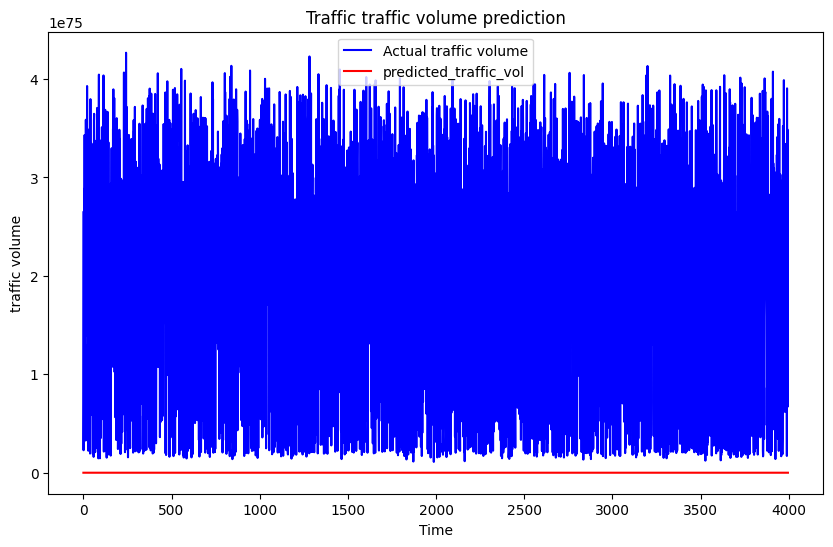

In [153]:
#inverse transorm to get actual traffic volume
predicted_traffic_vol=scaler.inverse_transform(predicted_traffic_vol.reshape(-1,1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
# Plot the results
import matplotlib.pyplot as plt

# Define the ticker or name here
ticker = "Traffic"

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Actual traffic volume')
plt.plot(predicted_traffic_vol, color='red', label='predicted_traffic_vol')
plt.title(f'{ticker} traffic volume prediction')
plt.xlabel('Time')
plt.ylabel('traffic volume')
plt.legend()
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

**LSTM model 2**

In [154]:
# Building the LSTM Model2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Define the LSTM model2
model2 = Sequential()

# Add LSTM layers with Dropout regularization
model2.add(LSTM(units=50, return_sequences=True, input_shape=(x.shape[1], x.shape[2])))
model2.add(Dropout(0.2))
model2.add(LSTM(units=50, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=50))
model2.add(Dropout(0.2))

# Add the output layer
model2.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [155]:
# Compile the model2
model2.compile(optimizer='adam', loss='mean_squared_error')

In [113]:
history = model2.fit(x, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - loss: 0.0162 - val_loss: 0.0139
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 0.0143 - val_loss: 0.0139
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - loss: 0.0143 - val_loss: 0.0142
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - loss: 0.0144 - val_loss: 0.0138
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 0.0142 - val_loss: 0.0139
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - loss: 0.0143 - val_loss: 0.0140
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - loss: 0.0141 - val_loss: 0.0140
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 0.0142 - val_loss: 0.0139
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - loss: 0.0144 - val_loss: 0.0140


### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [156]:
#make predictions 2
predicted_traffic_vol = model2.predict(x_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [157]:
#Evaluate the Model

# Predict on the test set
y_pred = model.predict(x_test)

# Inverse scale the predictions and true values
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred)
from sklearn.metrics import mean_squared_error
# Calculate evaluation metrics
rmse1 = np.sqrt(mean_squared_error(y_test,y_pred))
print(f'RMSE: {rmse}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE: 1.3761667050940564e+71


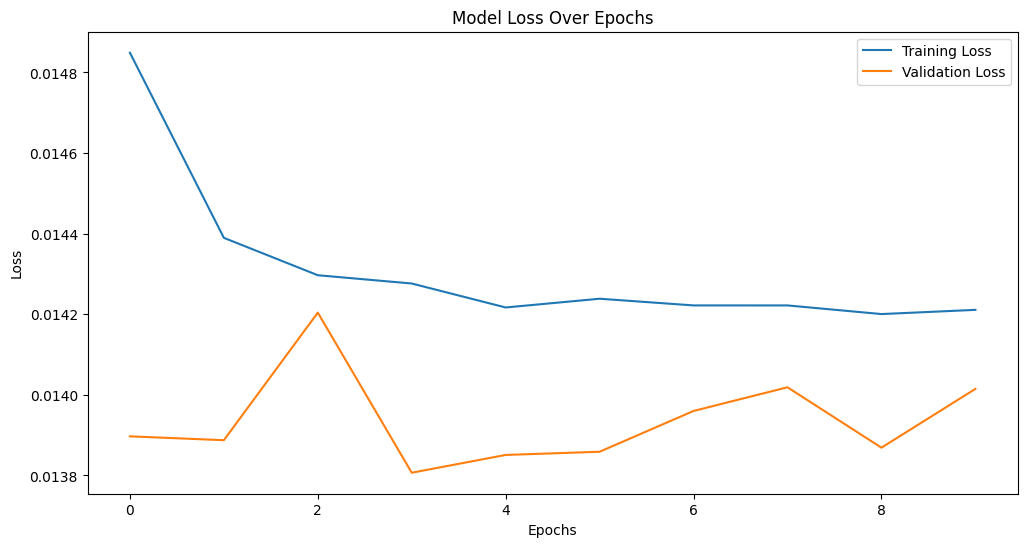

In [158]:


# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

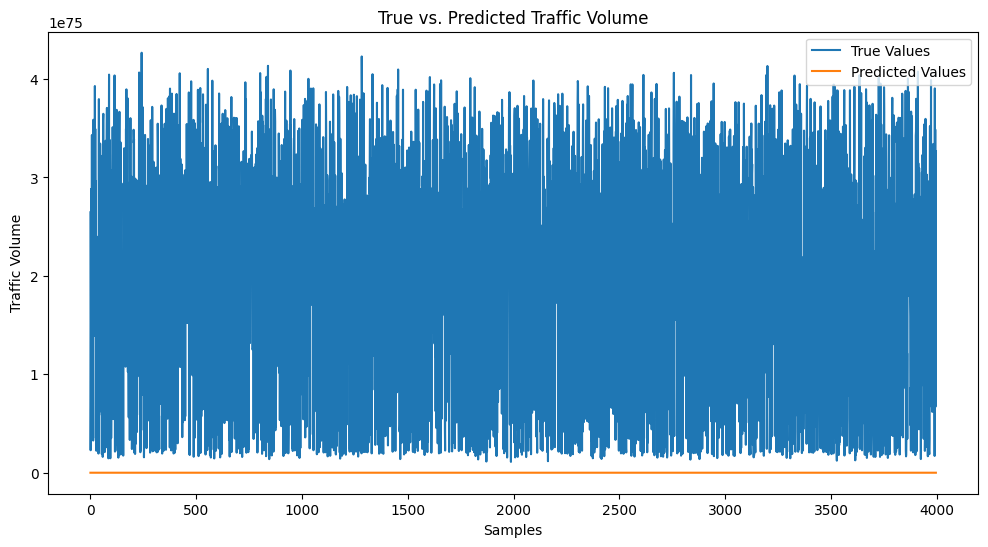

In [159]:
#Plot Predicted vs. True Values
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Plot predictions vs. true values
plt.figure(figsize=(12, 6))
plt.plot(y_test_flat, label='True Values')
plt.plot(y_pred_flat, label='Predicted Values')
plt.title('True vs. Predicted Traffic Volume')
plt.xlabel('Samples')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

In [ ]:
#LSTM did better for sure!


## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here: